# CNN for text classification handout
## [COSC 7336 Advanced Natural Language Processing](https://fagonzalezo.github.io/dl-tau-2017-2/)

In [1]:
import numpy as np
import pylab as pl
from IPython.display import SVG
from os.path import join, exists, split
import os

from gensim.models import word2vec, KeyedVectors


from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, GlobalMaxPooling1D
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

/home/juan/Programas/Miniconda3/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We will build the model presented in [Kim2014] using Keras. The code is based on the code from Alexander Rakhlin (https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras). 

The model is depicted in the next figure:

[Kim2014] Kim, Y. (2014). [Convolutional neural networks for sentence classification](https://arxiv.org/abs/1408.5882). arXiv preprint arXiv:1408.5882

![CNN model](kim2014cnn.jpg "cnn model")

First we define some general parameters

In [2]:
# Model Hyperparameters
embedding_dim = 300
filter_sizes = (3, 4, 5 )
num_filters = 100
dropout_prob = (0.0, 0.5)

# Training parameters
batch_size = 64
num_epochs = 10

# Prepossessing parameters
sequence_length = 20
max_words = 5000

# Word2Vec parameters 
min_word_count = 1
context = 10

We will use the the IMDB dataset provided by Keras. However, we will use only 1500 samples for training and 10000 for testing. 

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None,
                                                      oov_char=None, index_from=None)
x_train = x_train[:1500]
y_train = y_train[:1500]
x_test = x_test[:10000]
y_test = y_test[:10000]

x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")

vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))


x_train shape: (1500, 20)
x_test shape: (10000, 20)
Vocabulary Size: 88585


As described in the paper, one of the models uses a pretrained word2vec model to initialize the weights of the embedding layer. The pretrained model can be obtained from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [4]:
embedding_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
embedding_weights = {key: embedding_model[word] if word in embedding_model else
                          np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                     for key, word in vocabulary_inv.items()}

## CNN-rand 

The first model we will try is where all words are randomly initialized and then modified during training.

In [5]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(1, activation="sigmoid")(z)

# Model compilation
model_rand = Model(model_input, model_output)
model_rand.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

We can visualize the structure of the model:

_____________________________________________________________________________________
Layer (type)                Output Shape      Param #   Connected to                 
input_1 (InputLayer)        (None, 20)        0                                      
_____________________________________________________________________________________
embedding (Embedding)       (None, 20, 300)   26575500  input_1[0][0]                
_____________________________________________________________________________________
conv1d_1 (Conv1D)           (None, 18, 100)   90100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_2 (Conv1D)           (None, 17, 100)   120100    embedding[0][0]              
_____________________________________________________________________________________
conv1d_3 (Conv1D)           (None, 16, 100)   150100    embedding[0][0]              
______________________________________________________

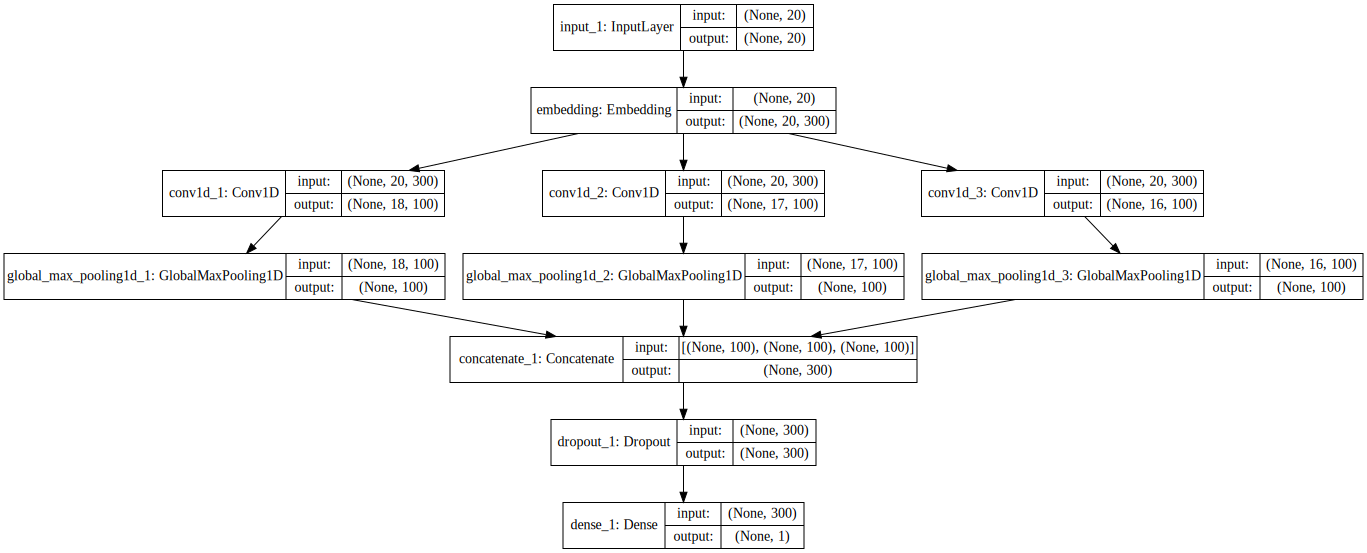

In [6]:
model_rand.summary(85)
SVG(model_to_dot(model_rand, show_shapes=True).create(prog='dot', format='svg'))

Now we are ready to train the model:

In [7]:
num_epochs = 10
history_rand = model_rand.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Train on 1500 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.6909 - acc: 0.5367 - val_loss: 0.6852 - val_acc: 0.5851
Epoch 2/10
 - 1s - loss: 0.6249 - acc: 0.7987 - val_loss: 0.6711 - val_acc: 0.6075
Epoch 3/10
 - 1s - loss: 0.5452 - acc: 0.8587 - val_loss: 0.6490 - val_acc: 0.6153
Epoch 4/10
 - 1s - loss: 0.4178 - acc: 0.9160 - val_loss: 0.6254 - val_acc: 0.6370
Epoch 5/10
 - 1s - loss: 0.2730 - acc: 0.9500 - val_loss: 0.6496 - val_acc: 0.6369
Epoch 6/10
 - 1s - loss: 0.1497 - acc: 0.9800 - val_loss: 0.7212 - val_acc: 0.6366
Epoch 7/10
 - 1s - loss: 0.0719 - acc: 0.9967 - val_loss: 0.8382 - val_acc: 0.6312
Epoch 8/10
 - 1s - loss: 0.0356 - acc: 0.9987 - val_loss: 0.9433 - val_acc: 0.6260
Epoch 9/10
 - 1s - loss: 0.0196 - acc: 1.0000 - val_loss: 1.0398 - val_acc: 0.6247
Epoch 10/10
 - 1s - loss: 0.0128 - acc: 1.0000 - val_loss: 1.1185 - val_acc: 0.6224


We can visualize the evolution of loss and accuracy for both the training and validation sets:

Text(0,0.5,'Loss')

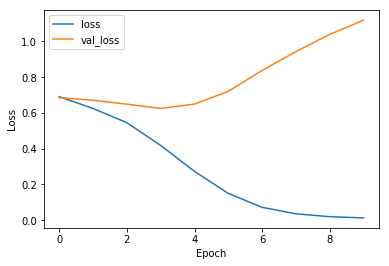

In [8]:
pl.plot(history_rand.history['loss'], label='loss')
pl.plot(history_rand.history['val_loss'], label='val_loss')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Loss')

Text(0,0.5,'Accuracy')

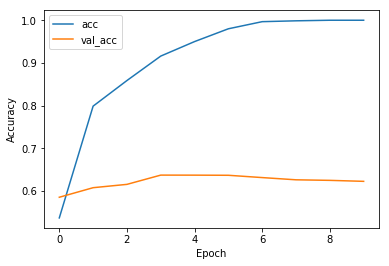

In [9]:
pl.plot(history_rand.history['acc'], label='acc')
pl.plot(history_rand.history['val_acc'], label='val_acc')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Accuracy')

## CNN-static

This model uses word2vec vectors to initialize the embedding. The weights of the embedding are kept fixed so they are not modified by training.

In [10]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)
weights = np.array([embedding_weights[i] for i in range(len(embedding_weights))])
print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer.set_weights([weights])

# Weights is embedding layer are not modified during training
embedding_layer.trainable = False

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(1, activation="sigmoid")(z)

# Model compilation
model_static = Model(model_input, model_output)
model_static.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Initializing embedding layer with word2vec weights, shape (88585, 300)


In [11]:
model_static.summary(85)

_____________________________________________________________________________________
Layer (type)                Output Shape      Param #   Connected to                 
input_2 (InputLayer)        (None, 20)        0                                      
_____________________________________________________________________________________
embedding (Embedding)       (None, 20, 300)   26575500  input_2[0][0]                
_____________________________________________________________________________________
conv1d_4 (Conv1D)           (None, 18, 100)   90100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_5 (Conv1D)           (None, 17, 100)   120100    embedding[0][0]              
_____________________________________________________________________________________
conv1d_6 (Conv1D)           (None, 16, 100)   150100    embedding[0][0]              
______________________________________________________

In [12]:
num_epochs = 10
history_static = model_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Train on 1500 samples, validate on 10000 samples
Epoch 1/10
 - 0s - loss: 0.6925 - acc: 0.5580 - val_loss: 0.6584 - val_acc: 0.6020
Epoch 2/10
 - 0s - loss: 0.5840 - acc: 0.7013 - val_loss: 0.6420 - val_acc: 0.6298
Epoch 3/10
 - 0s - loss: 0.4991 - acc: 0.8087 - val_loss: 0.6241 - val_acc: 0.6516
Epoch 4/10
 - 0s - loss: 0.4374 - acc: 0.8513 - val_loss: 0.6106 - val_acc: 0.6567
Epoch 5/10
 - 0s - loss: 0.3809 - acc: 0.8893 - val_loss: 0.6047 - val_acc: 0.6617
Epoch 6/10
 - 0s - loss: 0.3269 - acc: 0.9233 - val_loss: 0.6015 - val_acc: 0.6649
Epoch 7/10
 - 0s - loss: 0.2787 - acc: 0.9460 - val_loss: 0.5988 - val_acc: 0.6679
Epoch 8/10
 - 0s - loss: 0.2225 - acc: 0.9747 - val_loss: 0.6081 - val_acc: 0.6638
Epoch 9/10
 - 0s - loss: 0.1953 - acc: 0.9673 - val_loss: 0.6026 - val_acc: 0.6697
Epoch 10/10
 - 0s - loss: 0.1618 - acc: 0.9847 - val_loss: 0.6178 - val_acc: 0.6665


Text(0,0.5,'Loss')

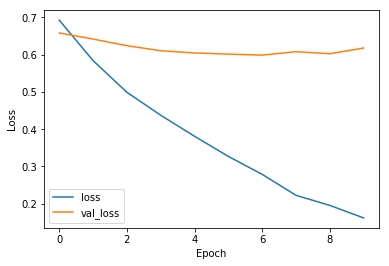

In [13]:
pl.plot(history_static.history['loss'], label='loss')
pl.plot(history_static.history['val_loss'], label='val_loss')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Loss')

Text(0,0.5,'Accuracy')

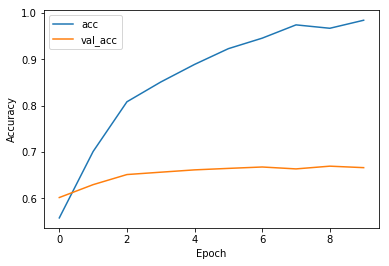

In [14]:
pl.plot(history_static.history['acc'], label='acc')
pl.plot(history_static.history['val_acc'], label='val_acc')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Accuracy')

## CNN-non-static

This model is same as the previous one, but the embedding weights are allowed to change during training.

In [15]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)
weights = np.array([embedding_weights[i] for i in range(len(embedding_weights))])
print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer.set_weights([weights])

# Weights is embedding layer are not modified during training
embedding_layer.trainable = True

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(1, activation="sigmoid")(z)

# Model compilation
model_non_static = Model(model_input, model_output)
model_non_static.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Initializing embedding layer with word2vec weights, shape (88585, 300)


In [16]:
num_epochs = 10
history_non_static = model_non_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Train on 1500 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.7154 - acc: 0.5220 - val_loss: 0.6668 - val_acc: 0.5905
Epoch 2/10
 - 1s - loss: 0.5600 - acc: 0.7260 - val_loss: 0.6316 - val_acc: 0.6446
Epoch 3/10
 - 1s - loss: 0.4506 - acc: 0.8500 - val_loss: 0.6109 - val_acc: 0.6651
Epoch 4/10
 - 1s - loss: 0.3639 - acc: 0.9080 - val_loss: 0.6027 - val_acc: 0.6683
Epoch 5/10
 - 1s - loss: 0.2713 - acc: 0.9427 - val_loss: 0.6027 - val_acc: 0.6711
Epoch 6/10
 - 1s - loss: 0.1956 - acc: 0.9700 - val_loss: 0.6140 - val_acc: 0.6689
Epoch 7/10
 - 1s - loss: 0.1413 - acc: 0.9873 - val_loss: 0.6282 - val_acc: 0.6735
Epoch 8/10
 - 1s - loss: 0.0983 - acc: 0.9940 - val_loss: 0.6457 - val_acc: 0.6712
Epoch 9/10
 - 1s - loss: 0.0705 - acc: 1.0000 - val_loss: 0.6720 - val_acc: 0.6698
Epoch 10/10
 - 1s - loss: 0.0503 - acc: 0.9993 - val_loss: 0.7051 - val_acc: 0.6694


Text(0,0.5,'Loss')

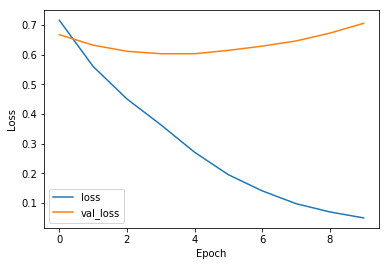

In [17]:
pl.plot(history_non_static.history['loss'], label='loss')
pl.plot(history_non_static.history['val_loss'], label='val_loss')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Loss')

Text(0,0.5,'Accuracy')

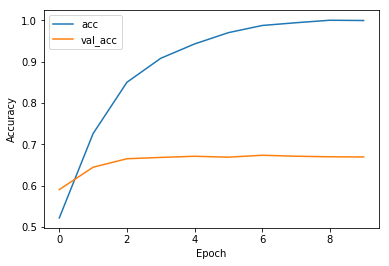

In [18]:
pl.plot(history_non_static.history['acc'], label='acc')
pl.plot(history_non_static.history['val_acc'], label='val_acc')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Accuracy')

Text(0,0.5,'Validation Accuracy')

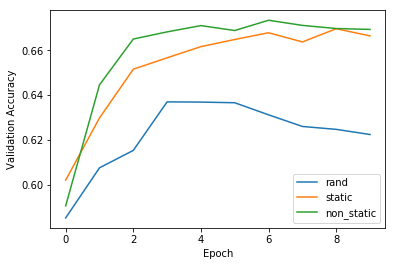

In [19]:
pl.plot(history_rand.history['val_acc'], label='rand')
pl.plot(history_static.history['val_acc'], label='static')
pl.plot(history_non_static.history['val_acc'], label='non_static')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Validation Accuracy')

The word2vec initialization gives a boost of around 4%. Allowing the embedding to fine tune has a small advantage.
## Increasing the data

Now, we will increase the amount of data for training to 25000 samples.

In [20]:
from keras import backend as K

def re_initialize(model):
    session = K.get_session()
    for layer in model.layers: 
         for v in layer.__dict__:
             v_arg = getattr(layer,v)
             if hasattr(v_arg,'initializer'):
                 initializer_method = getattr(v_arg, 'initializer')
                 initializer_method.run(session=session)
                 print('reinitializing layer {}.{}'.format(layer.name, v))

In [21]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None,
                                                      oov_char=None, index_from=None)

x_test = x_test[:10000]
y_test = y_test[:10000]

x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")

vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))


x_train shape: (25000, 20)
x_test shape: (10000, 20)
Vocabulary Size: 88585


In [22]:
num_epochs = 10
re_initialize(model_rand)
history_rand = model_rand.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

reinitializing layer embedding.embeddings
reinitializing layer conv1d_1.kernel
reinitializing layer conv1d_1.bias
reinitializing layer conv1d_2.kernel
reinitializing layer conv1d_2.bias
reinitializing layer conv1d_3.kernel
reinitializing layer conv1d_3.bias
reinitializing layer dense_1.kernel
reinitializing layer dense_1.bias
Train on 25000 samples, validate on 10000 samples
Epoch 1/10
 - 6s - loss: 0.5939 - acc: 0.6696 - val_loss: 0.5546 - val_acc: 0.7060
Epoch 2/10
 - 6s - loss: 0.4696 - acc: 0.7742 - val_loss: 0.5659 - val_acc: 0.7059
Epoch 3/10
 - 6s - loss: 0.3750 - acc: 0.8331 - val_loss: 0.5967 - val_acc: 0.6927
Epoch 4/10
 - 6s - loss: 0.2695 - acc: 0.8924 - val_loss: 0.7009 - val_acc: 0.6881
Epoch 5/10
 - 6s - loss: 0.1692 - acc: 0.9380 - val_loss: 0.8607 - val_acc: 0.6866
Epoch 6/10
 - 6s - loss: 0.1075 - acc: 0.9642 - val_loss: 0.9890 - val_acc: 0.6796
Epoch 7/10
 - 6s - loss: 0.0716 - acc: 0.9780 - val_loss: 1.1377 - val_acc: 0.6817
Epoch 8/10
 - 6s - loss: 0.0494 - acc: 0.

In [23]:
num_epochs = 10
re_initialize(model_static)
embedding_layer = model_static.get_layer("embedding")
embedding_layer.set_weights([weights])
history_static = model_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

reinitializing layer embedding.embeddings
reinitializing layer conv1d_4.kernel
reinitializing layer conv1d_4.bias
reinitializing layer conv1d_5.kernel
reinitializing layer conv1d_5.bias
reinitializing layer conv1d_6.kernel
reinitializing layer conv1d_6.bias
reinitializing layer dense_2.kernel
reinitializing layer dense_2.bias
Train on 25000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.6082 - acc: 0.6570 - val_loss: 0.5668 - val_acc: 0.6935
Epoch 2/10
 - 2s - loss: 0.5375 - acc: 0.7241 - val_loss: 0.5591 - val_acc: 0.7002
Epoch 3/10
 - 2s - loss: 0.5016 - acc: 0.7502 - val_loss: 0.5554 - val_acc: 0.7034
Epoch 4/10
 - 2s - loss: 0.4640 - acc: 0.7761 - val_loss: 0.5575 - val_acc: 0.7027
Epoch 5/10
 - 2s - loss: 0.4263 - acc: 0.8047 - val_loss: 0.5621 - val_acc: 0.7015
Epoch 6/10
 - 2s - loss: 0.3776 - acc: 0.8333 - val_loss: 0.5684 - val_acc: 0.7026
Epoch 7/10
 - 2s - loss: 0.3425 - acc: 0.8519 - val_loss: 0.5827 - val_acc: 0.7018
Epoch 8/10
 - 2s - loss: 0.2979 - acc: 0.

In [24]:
num_epochs = 10
re_initialize(model_non_static)
embedding_layer = model_non_static.get_layer("embedding")
embedding_layer.set_weights([weights])
history_non_static = model_non_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

reinitializing layer embedding.embeddings
reinitializing layer conv1d_7.kernel
reinitializing layer conv1d_7.bias
reinitializing layer conv1d_8.kernel
reinitializing layer conv1d_8.bias
reinitializing layer conv1d_9.kernel
reinitializing layer conv1d_9.bias
reinitializing layer dense_3.kernel
reinitializing layer dense_3.bias
Train on 25000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 0.5854 - acc: 0.6808 - val_loss: 0.5435 - val_acc: 0.7131
Epoch 2/10
 - 7s - loss: 0.4673 - acc: 0.7755 - val_loss: 0.5487 - val_acc: 0.7138
Epoch 3/10
 - 7s - loss: 0.3924 - acc: 0.8234 - val_loss: 0.5728 - val_acc: 0.7061
Epoch 4/10
 - 6s - loss: 0.3119 - acc: 0.8699 - val_loss: 0.6218 - val_acc: 0.7021
Epoch 5/10
 - 6s - loss: 0.2292 - acc: 0.9126 - val_loss: 0.7038 - val_acc: 0.6975
Epoch 6/10
 - 6s - loss: 0.1622 - acc: 0.9427 - val_loss: 0.7741 - val_acc: 0.6923
Epoch 7/10
 - 6s - loss: 0.1094 - acc: 0.9633 - val_loss: 0.9104 - val_acc: 0.6965
Epoch 8/10
 - 6s - loss: 0.0785 - acc: 0.

Text(0,0.5,'Validation Accuracy')

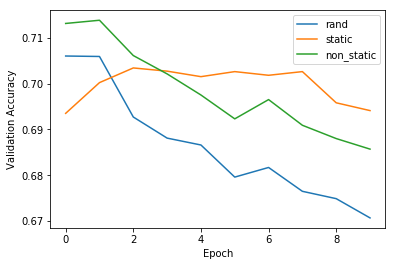

In [25]:
pl.plot(history_rand.history['val_acc'], label='rand')
pl.plot(history_static.history['val_acc'], label='static')
pl.plot(history_non_static.history['val_acc'], label='non_static')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Validation Accuracy')

The rand and non_static models overfit. There is not a clear advantage on using word2vec vectors to initialize weights.